In [2]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import nltk

from sklearn.decomposition import PCA
from matplotlib.ticker import MaxNLocator
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import KBinsDiscretizer
from scipy.spatial import distance

In [3]:
# Load Data
train_DF = pd.read_csv("./SWaT_train.csv")
test_DF = pd.read_csv("./SWaT_test.csv")

In [4]:
# Drop columns that are irrelevant to the fitting process
all_train = train_DF.drop(columns=['Normal/Attack', ' Timestamp'])
test = test_DF.drop(columns=['Normal/Attack', ' Timestamp', 'Unnamed: 0'])

# PCA

## Abnormalities in training data

The signals have not yet completely started their normal behaviour in the first few hours, because the system is still being initialized. In the graph below we can see an example of a signal for which this creates a number of serious outliers. Since we only want to model the normal behaviour in our PCA, we will get rid of this information for now, as to not take on unnecessary variance into our PCA representation.

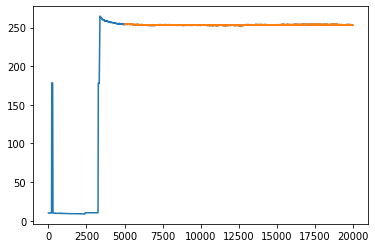

In [5]:
plt.plot(all_train['PIT501'][0:20000])
train = all_train[5000:]
plt.plot(train['PIT501'][0:15000])

# Scale data
scaler = preprocessing.StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.fit_transform(test)

In [6]:
# Fit PCA on the training data for different amounts of components
indices = []
scores = []
for i in range(len(train.columns) - 40, len(train.columns) - 14):
    model = PCA(n_components=i)
    model.fit(train_scaled)
    score = model.score(train_scaled)

    indices.append(i)
    scores.append(score)

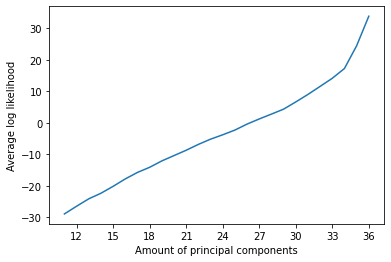

In [7]:
# Plot relation
plt.plot(indices, scores)
plt.xlabel("Amount of principal components")
plt.ylabel("Average log likelihood")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

The plot above describes the average log likelihood of the samples in the training data when explained by the distribution that is the result of the principal component analysis, in addition to its relation to the dimensionality of the space obtained in the PCA. As expected, one can clearly observe that as the dimensionality increases the explainability increases with it. However, we would like to find a sweet spot where most of the variance is explained while keeping as little dimensions as possible. This is crucial to ensure our PCA encodes a compact representation of benign cases, so that we can use it to detect anomalies later. In the graph we can see that at 20 components, the relation starts to change. The rate at which additional components increase the explainability of the data, starts to decrease. For our final model, we will therefore use a PCA with 20 components.

In [8]:
def calcAndPlotPerformance(components):
    # Fit the model with investigated amount of principal components
    model = PCA(n_components=components)
    model.fit(train_scaled)

    # Calculate the explainability of the test data
    avg = model.score(test_scaled)
    sample_scores = model.score_samples(test_scaled)

    # Make a groundtruth - prediction dataframe
    pred = pd.DataFrame(test_DF['Normal/Attack'])
    categories = {'Normal': 0, 'Attack' : 1}
    pred['Normal/Attack'] = pred['Normal/Attack'].map(categories)
    pred['prediction'] = sample_scores
    pred['prediction'].values[pred['prediction'].values < 1.5 * avg] = 1
    pred['prediction'].values[pred['prediction'].values != 1] = 0

    # Plot the confusion matrix
    cm = confusion_matrix(pred['Normal/Attack'], pred['prediction'])
    cm = pd.DataFrame(
            cm, 
            index = [i for i in ['Normal', 'Attack']],
            columns = [i for i in ['Normal', 'Attack']])

    plt.figure(figsize = (6,6))
    sb.heatmap(cm, annot=True, fmt='g')
    plt.xlabel("Predicted")
    plt.ylabel("Ground Truth")

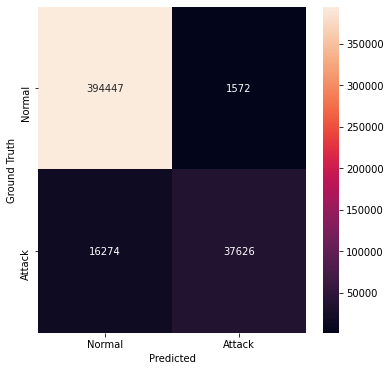

In [9]:
calcAndPlotPerformance(20)

## How does PCA based anomaly detection perform?

The confusion matrix above still shows a large amount of false negatives. This may be due to the fact that temporal relations are very important, PCA assumes there are no such temporal relations. In addition to this, the space is very high-dimensional and quite choatic, this means that benign data points are already very hard to explain with the initial distribution, let alone the lower-dimensional distribution. Apparently it is not the case that a compact representation can be found of the chronologically unordered data points, such that outliers will have a higher variance in this representative space compared to inliers.

## What type of anomalies are detected?

In fact the type of outliers it detects can be seen as global outliers, in the temporal sense of the word. Where a model like ARMA will learn a temporal model on the signals and detect outliers based on predictions, PCA will learn a representation of what is normal in the entire temporal dimension, which means the chronological information is lost. So, when PCA detects an outlier it means the data point is anomalous in and of itself. However, data points that may be perfectly inlying in the complete space but that are anomalous in their temporal context, may not be detected.

# N-GRAMS

## Discretization

We will start off by discretizing 5 different signals, the graphs below visualize these discretizations.

In [10]:
timestamps = pd.to_datetime(train_DF[' Timestamp'])[5000:]

training = pd.DataFrame(train_scaled)
training.columns = train.columns

C:\Users\ynzbo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


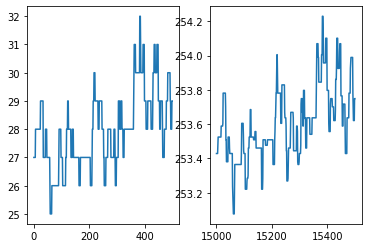

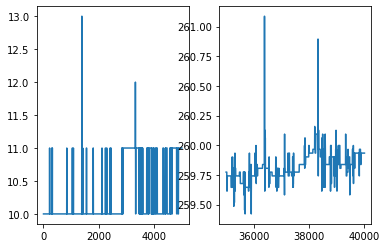

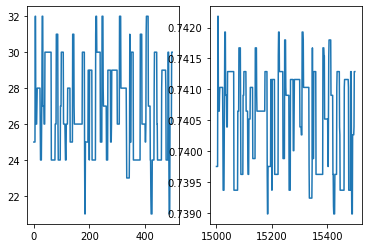

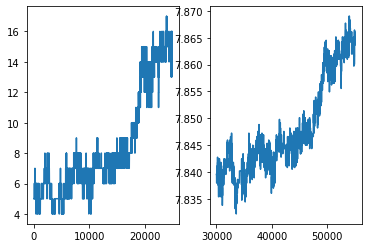

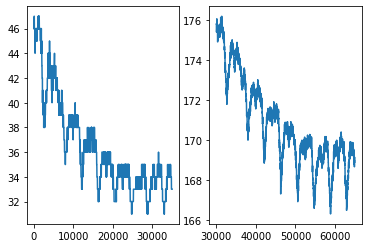

In [40]:
encoder = KBinsDiscretizer(n_bins=50, encode='ordinal')

training = pd.DataFrame(train_scaled)
training.columns = train.columns

enc1 = encoder.fit_transform(pd.DataFrame(training['PIT501']))
enc2 = encoder.fit_transform(pd.DataFrame(training['AIT201']))
enc3 = encoder.fit_transform(pd.DataFrame(training['FIT503']))
enc4 = encoder.fit_transform(pd.DataFrame(training['AIT501']))
enc5 = encoder.fit_transform(pd.DataFrame(training['AIT502']))

def plotDiscretization(columnName, enc, intervalBeg, intervalEnd):
    plt.subplot(1, 2, 1)
    plt.plot(enc[intervalBeg:intervalEnd])
    plt.subplot(1, 2, 2)
    plt.plot(train[columnName][intervalBeg:intervalEnd])
    plt.show()

plotDiscretization('PIT501', enc1, 10000, 10500)
plotDiscretization('AIT201', enc2, 30000, 35000)
plotDiscretization('FIT503', enc3, 10000, 10500)
plotDiscretization('AIT501', enc4, 25000, 50000)
plotDiscretization('AIT502', enc5, 25000, 60000)

## Creating Tables with N-Gram counts

In [41]:
def createNGRAMcounter(encoding, n, amountOfWindows):
    length = int(len(encoding) / amountOfWindows)
    counts = pd.DataFrame()
    signal = pd.DataFrame(encoding)
    signal.columns = ['column']
    for i in range(1, 100):
        temp = pd.Series(nltk.ngrams(signal['column'][(i-1)*length:i*length], n), name=i).value_counts()
        counts = pd.DataFrame.join(counts, temp, how='outer')

    return counts.fillna(0).T

In [42]:
# Calculate the counts of tri-grams in sliding windows 
pit501grams = createNGRAMcounter(enc1, 3, 100)
ait201grams = createNGRAMcounter(enc2, 3, 100)
fit503grams = createNGRAMcounter(enc3, 3, 100)
ait501grams = createNGRAMcounter(enc4, 3, 100)
ait502grams = createNGRAMcounter(enc5, 3, 100)

## Detect anomalies using cosine similarities between vectors in the n gram table.

In [43]:
def dist(x0, x1, x2, x3, grams):
    tuple1 = (float(str(x0)[1:-1] + "0"), float(str(x1)[1:-1] + "0"), float(str(x2)[1:-1] + "0"))
    tuple2 = (float(str(x1)[1:-1] + "0"), float(str(x2)[1:-1] + "0"), float(str(x3)[1:-1] + "0"))

    if tuple1 in grams.columns:
        col1 = grams[tuple1]
    else:
        col1 = grams["def"]

    if tuple2 in grams.columns:
        col2 = grams[tuple2]
    else:
        col2 = grams["def"]

    return distance.cosine(col1, col2)

def detectAnomalies(signal, grams, threshold):
    anomalies = np.zeros(len(signal))

    # add column for unseen combinations
    grams['def'] = 0
    
    # discretize signal
    encoder = KBinsDiscretizer(n_bins=10, encode='ordinal')
    signal = encoder.fit_transform(pd.DataFrame(signal))

    print("Busy, please wait...")
    # loop through signal to find anomalies
    for i in range(0, len(signal) - 3):
        if dist(signal[i], signal[i + 1], signal[i + 2], signal[i + 3], grams) > threshold:
            anomalies[i+3] = 1
        else:
            anomalies[i+3] = 0

    return anomalies

def plotResults(prediction):
    # Make a groundtruth - prediction dataframe
    comparison = pd.DataFrame(test_DF['Normal/Attack'])
    categories = {'Normal': 0, 'Attack' : 1}
    comparison['Normal/Attack'] = comparison['Normal/Attack'].map(categories)
    comparison['prediction'] = prediction

    # Plot the confusion matrix
    cm = confusion_matrix(comparison['Normal/Attack'], comparison['prediction'])
    cm = pd.DataFrame(
            cm, 
            index = [i for i in ['Normal', 'Attack']],
            columns = [i for i in ['Normal', 'Attack']])

    plt.figure(figsize = (6,6))
    sb.heatmap(cm, annot=True, fmt='g')
    plt.xlabel("Predicted")
    plt.ylabel("Ground Truth")

## Plot results in a confusion matrix

Busy, please wait...
C:\Users\ynzbo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


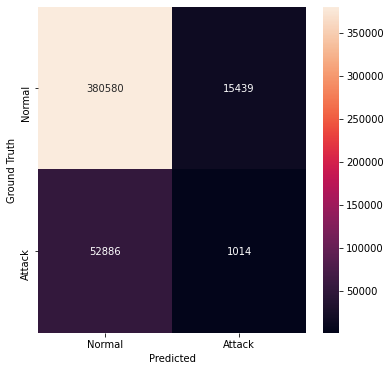

In [47]:
# PIT501
pred = detectAnomalies(test['PIT501'], pit501grams, 0.05)
plotResults(pred)

Busy, please wait...
C:\Users\ynzbo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


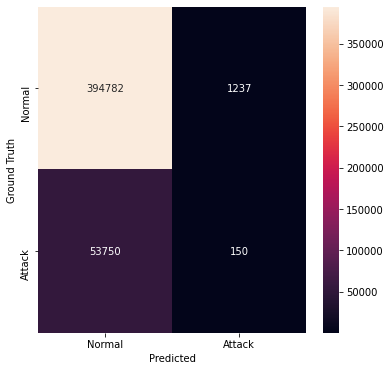

In [48]:
# AIT201
pred = detectAnomalies(test[' AIT201'], ait201grams, 0.1)
plotResults(pred)

Busy, please wait...
C:\Users\ynzbo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


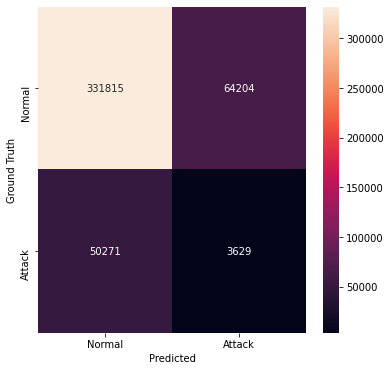

In [52]:
# FIT503
pred = detectAnomalies(test['FIT503'], fit503grams, 0.1)
plotResults(pred)

Busy, please wait...
C:\Users\ynzbo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


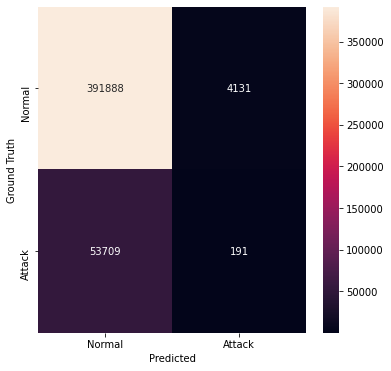

In [50]:
# AIT501
pred = detectAnomalies(test['AIT501'], ait501grams, 0.05)
plotResults(pred)

Busy, please wait...
C:\Users\ynzbo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


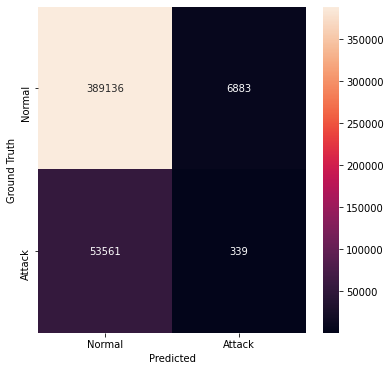

In [51]:
# AIT502
pred = detectAnomalies(test['AIT502'], ait502grams, 0.05)
plotResults(pred)

## Discussion

The results for N-gram are quite dissapointing on all signals. It may be the case that the amount of bins in the discretization is either too low to capture relevant information or too high and the N-gram matrix becomes too sparse. It may also be the case that the optimal thresholds for the cosine similarities are very different for different signals. Alternatively it could be that that trigrams are simply not sufficient to detect long temporal relations and thus fail to detect anomalies in this temporal dimension.